In [2]:
import numpy as np
import os, re, cv2
from cellpose import utils
from skimage.morphology import skeletonize
import warnings
import copy
import tools
import matplotlib.pyplot as plt
from numba_transforms import nn_scale_image

segments_path = "cellpose_output/"

In [3]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [5]:
# Initialize lists.
outl_temp = []
maskl_temp = []
iml_temp = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original mask.
    maskl = tools.masks_list(dat['masks'])
    maskl_temp.append(maskl)
    
    #Populate list with each original image
    iml = dat['img']
    iml_temp.append(iml)

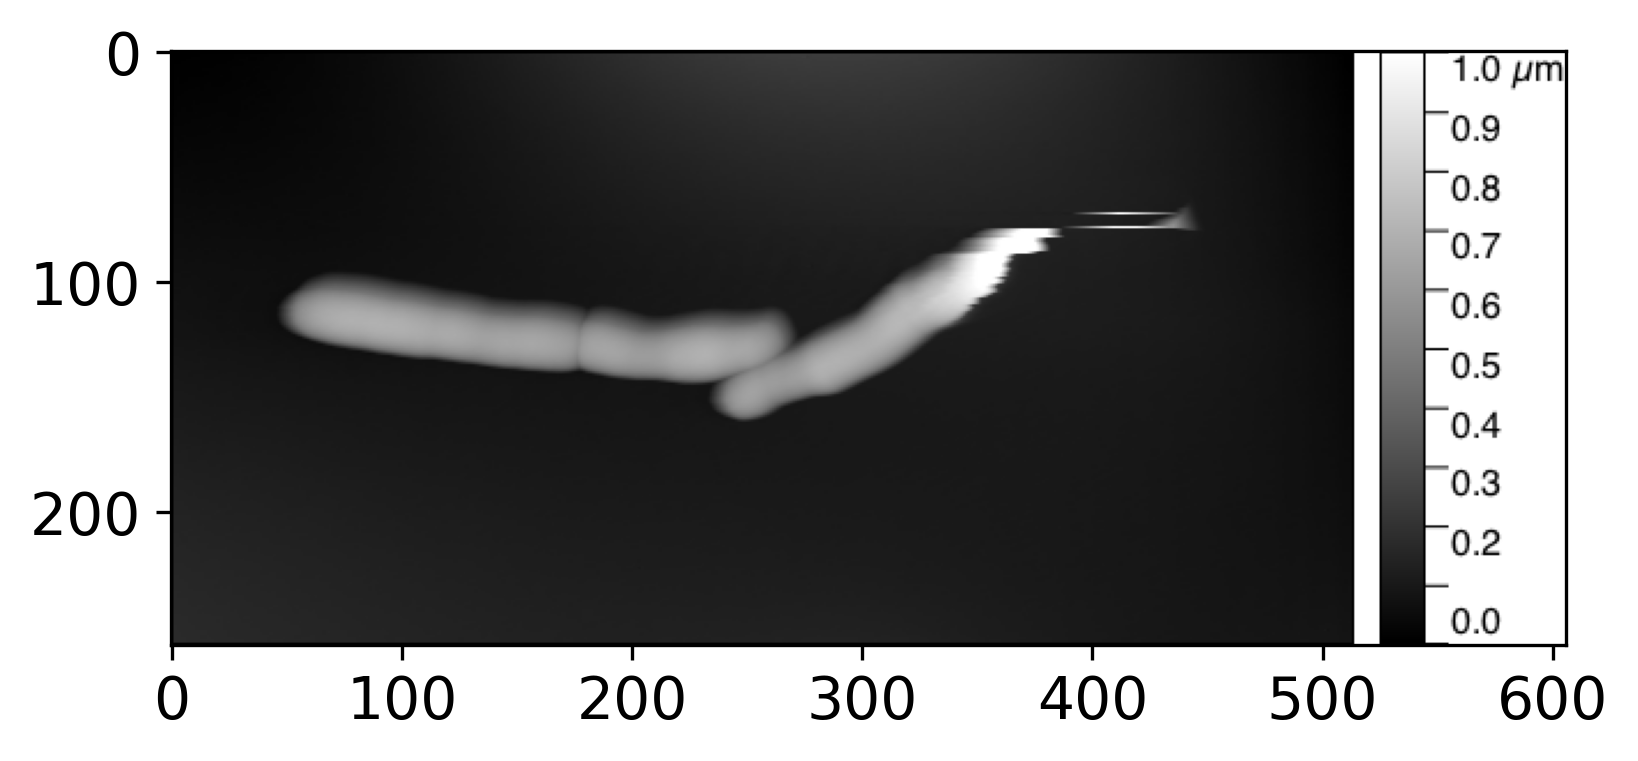

In [6]:
plt.imshow(iml_temp[21])

In [8]:
large_mask=copy.deepcopy(maskl_temp[21][2])
dmask = large_mask>0
mask = np.flip(dmask,axis=0).astype(np.uint8)
padded = cv2.copyMakeBorder(mask,1,1,1,1,cv2.BORDER_CONSTANT,None,value=0)
sk = copy.deepcopy(dmask)
sk = skeletonize(sk)
#plt.imshow(sk,cmap='gray')
#plt.axis('off')

(0.0, 607.0, 0.0, 259.0)

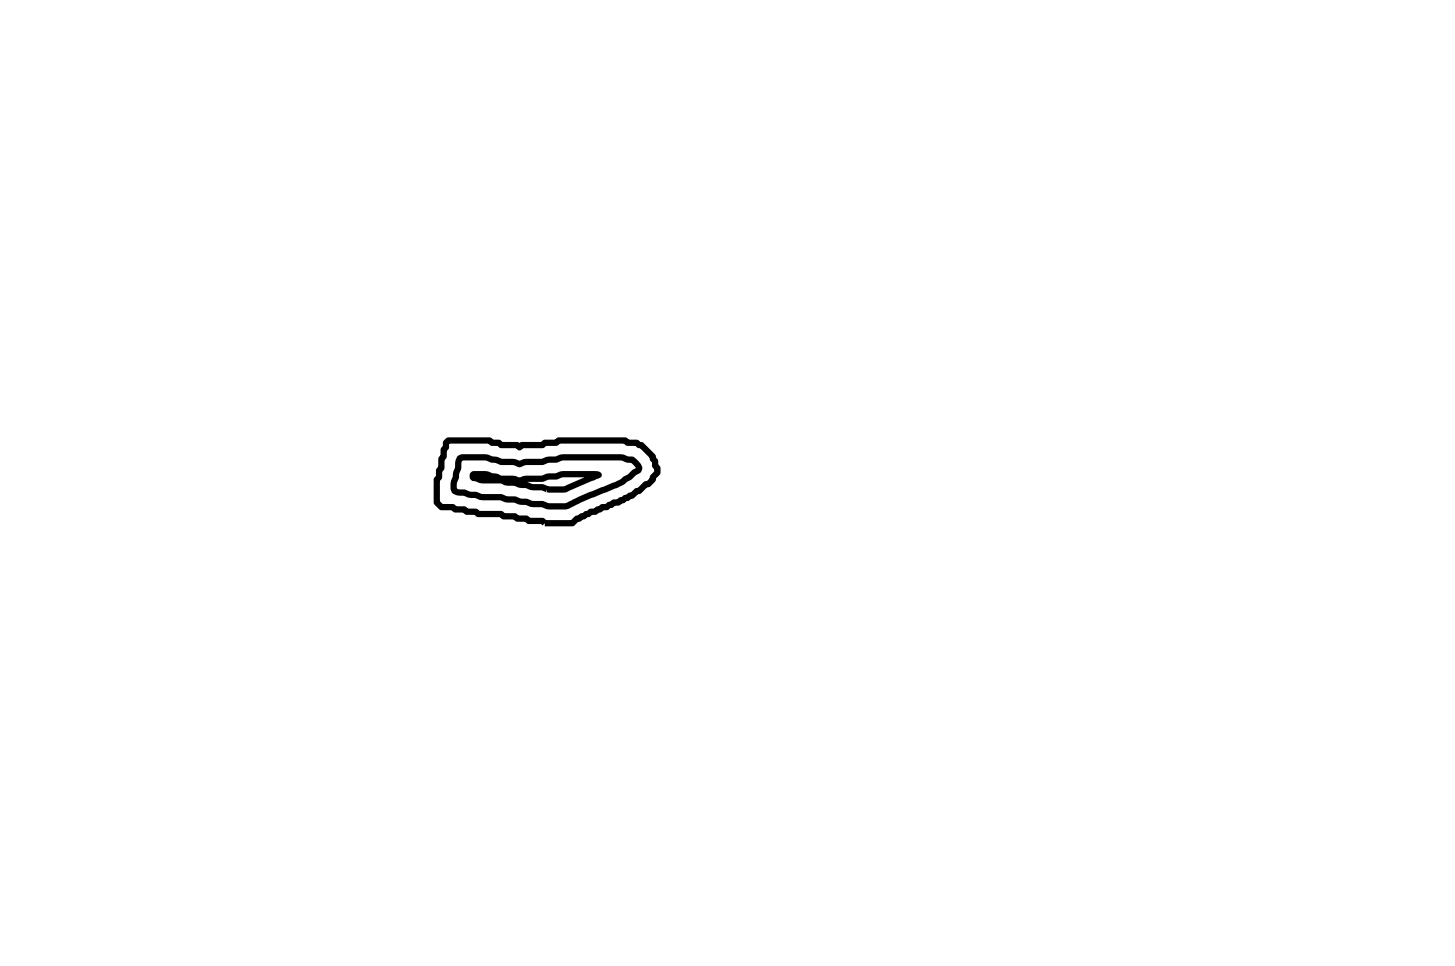

In [9]:
disT = cv2.distanceTransform(padded, cv2.DIST_L2, 3)
plt.contour(disT,[0,7,14],colors='black')
plt.axis('equal')
plt.axis('off')

In [428]:
def count(a, b, m,n):
    n = len(b)
    if (n == 0):
        return 1
    if (m < n):
        return 0
    if (a[m-n:m] == b):
        return (1 + 
                count(a, b, m - 1,n))
    else:
        return count(a, b, m - 1,n)

In [429]:
def iter1(mat):
    '''execute first subiteration of the zhang-suen algorithm
    Inputs
    mat = 3x3 boolean matrix
    
    Outputs
    bool = boolean, representing the center pixel of the matrix
    '''
    if mat[1,1] ==0:
        return 0
    else:
        B= np.sum(mat)-1
        A = count([mat[0,1],mat[0,2],mat[1,2],mat[2,2],mat[2,1],mat[2,0],mat[1,0],mat[0,0],mat[0,1]],[0,1],9,2)
        C = mat[0,1]*mat[1,2]*mat[2,1]
        D = mat[1,2]*mat[2,1]*mat[1,0]
        if B>=2 and B<=6 and A == 1 and C == 0 and D == 0:
            return 1
        else:
            return 0

def iter2(mat):
    '''execute first subiteration of the zhang-suen algorithm
    Inputs
    mat = 3x3 boolean matrix
    
    Outputs
    bool = boolean, representing the center pixel of the matrix
    '''
    mat = np.transpose(mat)
    if mat[1,1] ==0:
        return 0
    else:
        B= np.sum(mat)-1
        A = count([mat[0,1],mat[0,2],mat[1,2],mat[2,2],mat[2,1],mat[2,0],mat[1,0],mat[0,0],mat[0,1]],[0,1],9,2)
        C = mat[0,1]*mat[1,2]*mat[1,0]
        D = mat[0,1]*mat[2,1]*mat[1,0]
        if B>=2 and B<=6 and A == 1 and C == 0 and D == 0:
            return 1
        else:
            return 0

In [430]:
def zs_thin(mask, max_iter = np.infty,cur_iter = 0):
    padded = cv2.copyMakeBorder(mask,1,1,1,1,cv2.BORDER_CONSTANT,None,value=0)
    (m,n) = np.shape(mask)
    C = 0
    for i in range(m):
        for j in range(n):
            if iter1(padded[i:i+3,j:j+3]):
                mask[i,j] = 0
                C = C+1
    if C ==0:
        return mask
    for i in range(m):
        for j in range(n):
            if iter2(padded[i:i+3,j:j+3]):
                mask[i,j] = 0
                C = C+1
    if C == 0:
        return mask
    cur_iter = cur_iter + 1
    if cur_iter>max_iter:
        return mask
    else:
        return zs_thin(mask,max_iter,cur_iter)
        

(-0.5, 94.5, 34.5, -0.5)

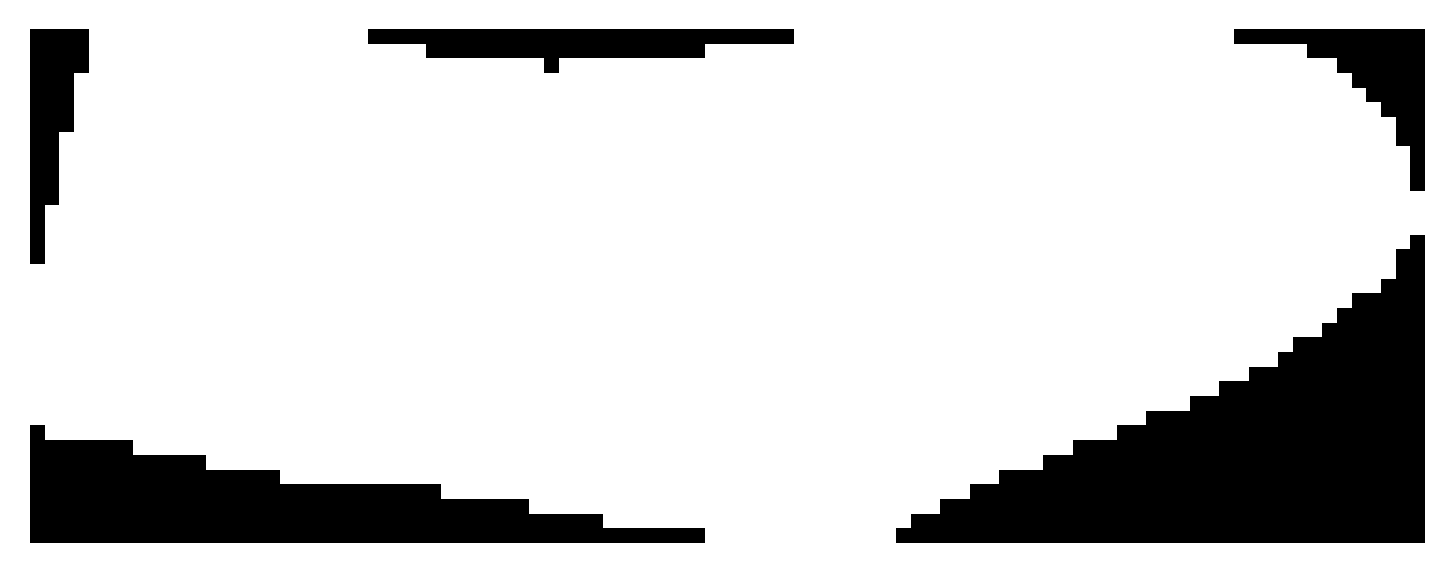

In [13]:
plt.imshow(dmask,cmap='gray')
plt.axis('off')

(-0.5, 94.5, 34.5, -0.5)

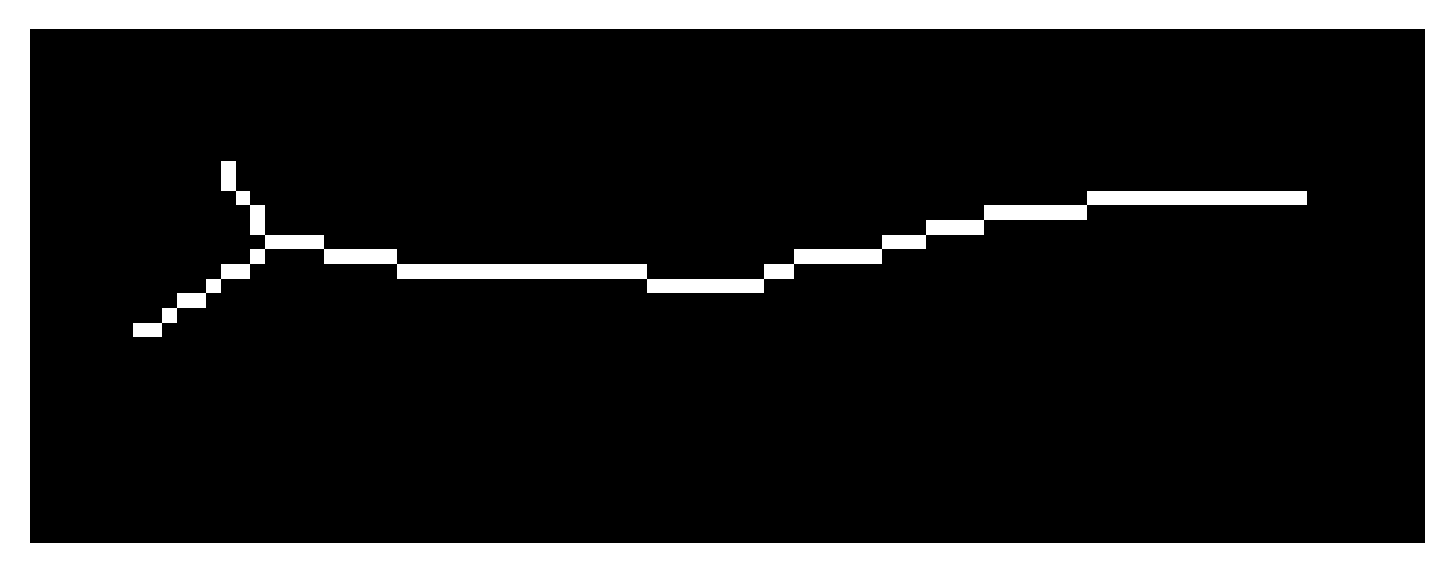

In [15]:
plt.imshow(sk,cmap='gray')
plt.axis('off')

In [441]:
skel2 = copy.deepcopy(dmask)
skel2 = skeletonize(skel2)

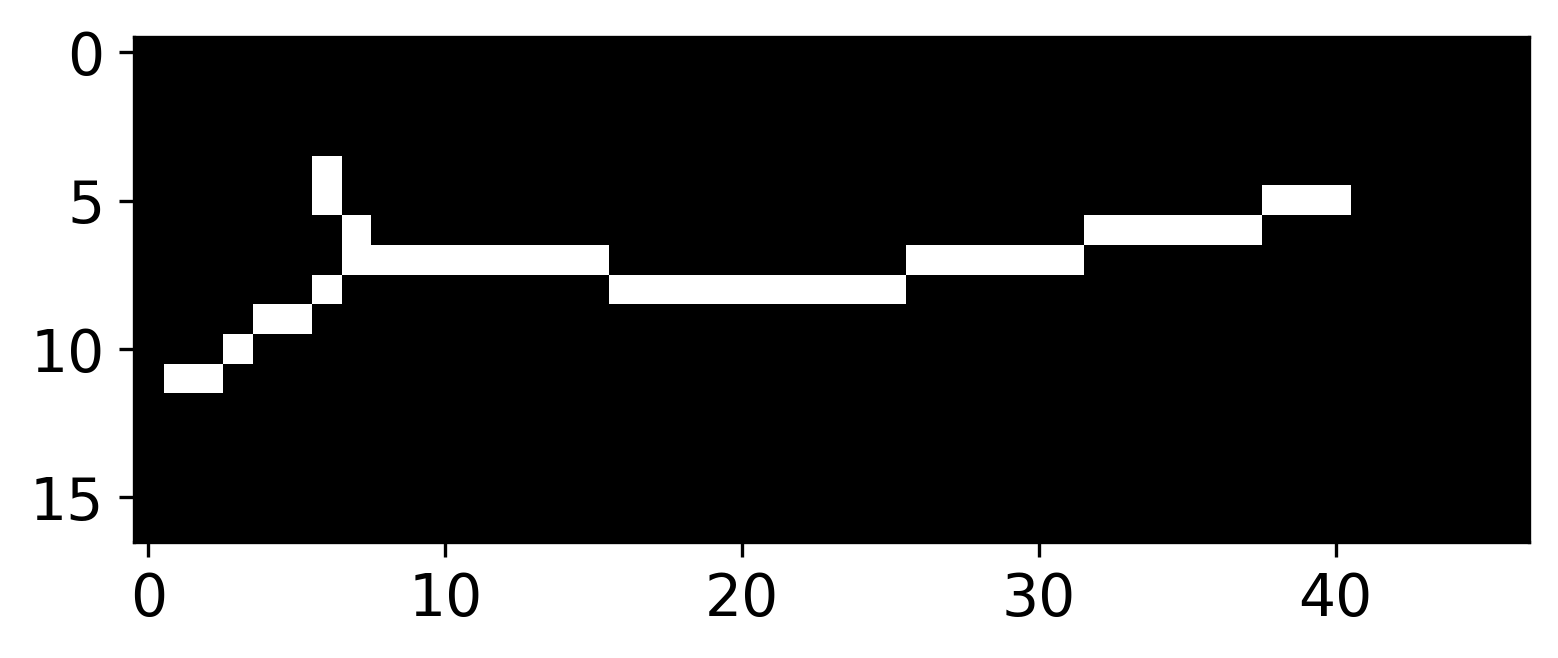

In [435]:
plt.imshow(skel2,cmap='gray')